# Week 8 - Language Modeling With an RNN
<i>MSDS422</i>

---
You are to compete in the Real or Not:  NLP with Disaster Tweets competition on Kaggle.com.  https://www.kaggle.com/c/nlp-getting-started/notebooks (Links to an external site.)

In this competition you will compete at least two varieties of RNN and submit your predictions to Kaggle.  RNNs are well suited to the analysis of sequences, as needed for natural language processing (NLP). Initial background reading for this assignment comes from Chapter 14 (pp. 379–411) of the Géron textbook:

## Assignment Requirements

* Compete in the Kaggle.com competition.
* Submit at least two models to Kaggle.com 
* Make recommendations to management

## Management Problem

Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

# Results:

I started by using Thomas Miller's Week 8 Jump Start file. This helped me with the data preparation however I felt he had a lot of extra code that was unnecessary (it was helpful for teaching purposes but wasn't needed for my analysis). It seems that since his code is from several years ago many things are quite different. Tensorflow is has changed drastically since them and I quickly found that there were portions of his code that would not run. I used his Glove.6B.100d.txt file to create an embeddings matrix based on the words in the tweets. I cleaned the tweets for all of the obvious unnecessary characters; punctuation, line breaks, emojis, and hyperlinks. 
Using this dataset I was able to create two LSTM RNN models with the help of some code from Kaggle. The first one used spatial dropout while the second employed a bidirectional layer. The first one performed better but strangly enough was having better results on the test set than the training set. The second model performed very well on the training set but didn't generalize well on the test set. 


|Model # | Layer | Training Accuracy | Test Accuracy| Kaggle Score (F1) |
| --- | --- | --- | --- | --- |
| 1 | Spatial Dropout | 79.93% | 81.16% | 0.78732 |
| 2 | Bidirctional | 98.52% | 76.36% | 0.76687 |


**Management Answer:** 

Based on my small test including a spatial dropout layer had better effects on accuracy (and F1) than including a Bidirectional layer. On the whole I was able to classify with about ~80% accuracy. Something similar could be used to identify the most negative reviews. That would actually be easier because out of 7k reviews you wouldn't be trying to identify ALL of the negative ones, just the MOST negative. This could be done by grabbing the ones that the model says has the highest likelyhood of being negative. 
One concern, as was experienced in this assignment, is that real world data is dirty. Especially free form unstructured text data. Great care has to be taken to remove all of the junk but not lose anything that could provide insight. On the whole though while not easy it is certainly possible for a model to be built that could identify the users that need to be contacted.

---


In [1]:
#Importing more libraries than are necessary

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, cv2, re, random
import time
import datetime

# Text Processing
import nltk
import gensim
import string
!pip install pyspellchecker
from spellchecker import SpellChecker
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

#Modeling
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras.initializers import Constant
from keras import backend as K

from sklearn.model_selection import train_test_split

!pip install chakin
import chakin  
%matplotlib inline
import json
import os
from collections import defaultdict
from collections import defaultdict
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

RANDOM_SEED = 1776

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.9MB 3.4MB/s 


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Prepping Kaggle data

In [ ]:
# installing the kaggle package
!pip install -U -q kaggle

# Making a new directory for kaggle
!mkdir -p ~/.kaggle

# Uploading my kaggle.json api key
from google.colab import files
files.upload()

In [0]:
# copying my api key to my new kaggle folder
!cp kaggle.json ~/.kaggle/

# Hiding my API key
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Grabbing dataset from kaggle
!kaggle competitions download -c nlp-getting-started 

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 62.8MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 58.0MB/s]


In [0]:
# Reading in datasets
df_train = pd.read_csv('/content/train.csv', header=0, sep=',', quotechar='"')
df_test = pd.read_csv('/content/test.csv', header=0, sep=',', quotechar='"')

## EDA

In [25]:
df_train.head()

,id,keyword,text,target,cleaned_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   text          7613 non-null   object
 3   target        7613 non-null   int64 
 4   cleaned_text  7613 non-null   object
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Keyword doesn't have many nulls (<1%) but location does (33%). Based on the prof's recommendation of >20% we'll drop this column.

In [28]:
df_train.describe(include = 'all')

,id,keyword,text,target,cleaned_text
count,7613.000000,7552,7613,7613.00000,7613
unique,NaN,221,7503,NaN,6955
top,NaN,fatalities,11-Year-Old Boy Charged With Manslaughter of T...,NaN,watch this airport get swallowed up by a sands...
freq,NaN,45,10,NaN,24
mean,5441.934848,NaN,NaN,0.42966,NaN
std,3137.116090,NaN,NaN,0.49506,NaN
min,1.000000,NaN,NaN,0.00000,NaN
25%,2734.000000,NaN,NaN,0.00000,NaN
50%,5408.000000,NaN,NaN,0.00000,NaN
75%,8146.000000,NaN,NaN,1.00000,NaN


In [29]:
# Checking 20 most common keywords
df_train.loc[:,'keyword'].value_counts()[0:20]

fatalities     45
deluge         42
armageddon     42
body%20bags    41
harm           41
sinking        41
damage         41
collided       40
twister        40
outbreak       40
evacuate       40
fear           40
siren          40
windstorm      40
wrecked        39
wreckage       39
earthquake     39
flames         39
weapons        39
sunk           39
Name: keyword, dtype: int64

In [30]:
# Checking record counts
print(len(df_train))
print(len(df_test))

7613
3263


0    4342
1    3271
Name: target, dtype: int64


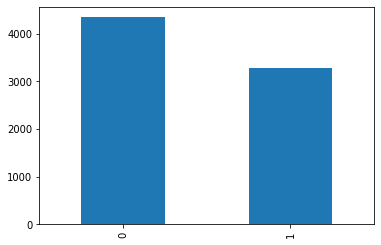

In [31]:
# Checking distribution of target variable
df_train.loc[:,'target'].value_counts().plot(kind = 'bar')
print(df_train.loc[:,'target'].value_counts())

Looks balanced enough for me

In [32]:
# Checking some of the tweets
df_train.loc[:,'text'][100:120]

100    .@NorwayMFA #Bahrain police had previously die...
101    I still have not heard Church Leaders of Kenya...
102    @afterShock_DeLo scuf ps live and the game... cya
103    'The man who can drive himself further once th...
104    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...
105    'There is no victory at bargain basement price...
106    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
107    'Nobody remembers who came in second.' Charles...
108    @afterShock_DeLo im speaking from someone that...
109    'The harder the conflict the more glorious the...
110    #GrowingUpSpoiled going clay pigeon shooting a...
111    So i guess no one actually wants any free Afte...
112    Aftershock was the most terrifying best roller...
113                   Aftershock https://t.co/xMWODFMtUI
114    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...
115    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
116    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...
117    @KJForDays I'm seeing th

Many seem to have URLs included. We'll need to remove these

Max tweet length: 157
Min tweet length: 7


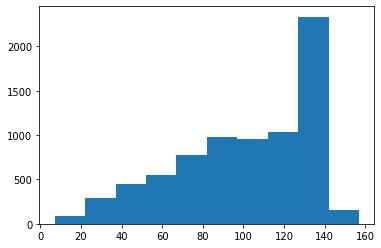

In [33]:
# Checking distribution of number of characters per tweet
a = []
for num in range(0,len(df_train)):
  a.append(len(df_train.loc[:,'text'][num]))


# Plotting histogram
ax = plt.hist(a)

print("Max tweet length:", max(a))
print("Min tweet length:", min(a))

**Takeaways:** Most tweets are using almost the maximum available characters, most are 130-140 characters long.

## Data Preprocessing

In [0]:
# Location is worthless so we're going to drop it
df_train.drop(['location'], axis = 1, inplace = True)
df_test.drop(['location'], axis = 1, inplace = True)

In [0]:
# Creating function to remove all of the junk from the tweets
def text_parse(data):
  # removing URLs
  url = re.compile(r'https?://\S+|www\.\S+')
  new = url.sub(r'',data)

  # Removing HTML tags:
  html=re.compile(r'<.*?>')
  new = html.sub(r'',new)

  # Remove Emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  new = emoji_pattern.sub(r'', new)

  # Removing punctuation
  table=str.maketrans('','',string.punctuation)
  new = new.translate(table)

  # Correcting misspelled words - Commenting out since it takes WAY too long
  #spell = SpellChecker()
  #corrected_text = []
  #misspelled_words = spell.unknown(new.split())
  #for word in new.split():
  #  if word in misspelled_words:
  #    corrected_text.append(spell.correction(word))
  #  else:
  #    corrected_text.append(word)
  #new = " ".join(corrected_text)

  return new

In [0]:
# Creating new function to change to lowercase and clean the data
def tweet_cleaner(data):
  data = tf.compat.as_str(data)
  data = data.lower()
  data =text_parse(data)
  return data

# Applying our function
df_train['cleaned_text'] = df_train['text'].apply(lambda x : tweet_cleaner(x))

In [9]:
# Creating Words Corpus
stop = set(stopwords.words('english'))

def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['cleaned_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
        corpus.append(words)
    return corpus

corpus = create_corpus(df_train)

100%|██████████| 7613/7613 [00:01<00:00, 7033.77it/s]


In [10]:
# Checking the corpus of our first word, stopwords removed
corpus[0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [0]:
# Manually uploaded gloVe file

# Creating embedding dictionary
embedding_dict={}
with open('/content/glove.6B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [22]:
# Checking the maximum/minimum length (in words) of all of our tweets

max_tweet_length = 0 
for doc in corpus:
    max_tweet_length = max(max_tweet_length, len(doc))     
print('max_tweet_length:', max_tweet_length) 

min_tweet_length = max_tweet_length
for doc in corpus:
    min_tweet_length = min(min_tweet_length, len(doc))    
print('min_tweet_length:', min_tweet_length) 

max_tweet_length: 23
min_tweet_length: 0


In [0]:
'''
The lengths of the tweets vary from 0 to 23 words. Setting all to 20 words
will pad those shorter and truncate those longer.
'''
MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [24]:
# Viewing the tokenized array of the first tweet
print("Original: ",df_train.loc[0,'cleaned_text'])
print("Corpus: ", corpus_pad[0])

Original:  our deeds are the reason of this earthquake may allah forgive us all
Corpus:  [4160  691  145   52 1399 4161   13    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [25]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16111


In [27]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16111/16111 [00:00<00:00, 547210.13it/s]


## Modeling

In [0]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, df_train['target'].values, test_size = 0.2, random_state = RANDOM_SEED )

In [0]:
# Model 1 - Long Short Term Memory network.
reset_graph()

model=Sequential()

embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam' , metrics=['accuracy'])

In [23]:
history=model.fit(X_train,y_train,batch_size=32,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/15
 - 3s - loss: 0.5624 - accuracy: 0.7163 - val_loss: 0.4669 - val_accuracy: 0.7899
Epoch 2/15
 - 3s - loss: 0.5196 - accuracy: 0.7552 - val_loss: 0.4586 - val_accuracy: 0.7958
Epoch 3/15
 - 3s - loss: 0.5100 - accuracy: 0.7629 - val_loss: 0.4547 - val_accuracy: 0.8004
Epoch 4/15
 - 3s - loss: 0.4987 - accuracy: 0.7760 - val_loss: 0.4611 - val_accuracy: 0.7958
Epoch 5/15
 - 3s - loss: 0.5033 - accuracy: 0.7672 - val_loss: 0.4601 - val_accuracy: 0.8024
Epoch 6/15
 - 3s - loss: 0.4971 - accuracy: 0.7677 - val_loss: 0.4532 - val_accuracy: 0.7984
Epoch 7/15
 - 3s - loss: 0.4948 - accuracy: 0.7706 - val_loss: 0.4503 - val_accuracy: 0.8011
Epoch 8/15
 - 3s - loss: 0.4915 - accuracy: 0.7739 - val_loss: 0.4495 - val_accuracy: 0.8004
Epoch 9/15
 - 3s - loss: 0.4798 - accuracy: 0.7805 - val_loss: 0.4494 - val_accuracy: 0.8043
Epoch 10/15
 - 3s - loss: 0.4818 - accuracy: 0.7773 - val_loss: 0.4517 - val_accuracy: 0.8129
Epoch 11/15
 - 3s - l

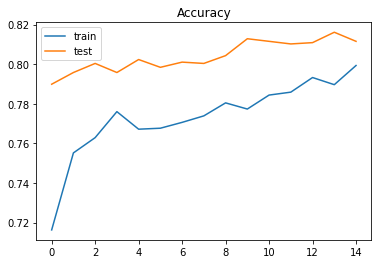

In [24]:
# Plotting accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [0]:
# Model 2 - Using a Bidirectional layer with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 100, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
history=model.fit(X_train,y_train,batch_size=32,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
191/191 - 8s - loss: 0.5413 - accuracy: 0.7197 - val_loss: 0.4421 - val_accuracy: 0.7958
Epoch 2/15
191/191 - 8s - loss: 0.2756 - accuracy: 0.8928 - val_loss: 0.4849 - val_accuracy: 0.7787
Epoch 3/15
191/191 - 7s - loss: 0.1465 - accuracy: 0.9494 - val_loss: 0.6024 - val_accuracy: 0.7722
Epoch 4/15
191/191 - 7s - loss: 0.0974 - accuracy: 0.9691 - val_loss: 0.7394 - val_accuracy: 0.7590
Epoch 5/15
191/191 - 7s - loss: 0.0703 - accuracy: 0.9745 - val_loss: 0.7194 - val_accuracy: 0.7590
Epoch 6/15
191/191 - 7s - loss: 0.0517 - accuracy: 0.9780 - val_loss: 0.8795 - val_accuracy: 0.7708
Epoch 7/15
191/191 - 8s - loss: 0.0411 - accuracy: 0.9819 - val_loss: 0.9142 - val_accuracy: 0.7649
Epoch 8/15
191/191 - 7s - loss: 0.0371 - accuracy: 0.9829 - val_loss: 0.9088 - val_accuracy: 0.7623
Epoch 9/15
191/191 - 7s - loss: 0.0365 - accuracy: 0.9819 - val_loss: 1.0458 - val_accuracy: 0.7472
Epoch 10/15
191/191 - 7s - loss: 0.0336 - accuracy: 0.9837 - val_loss: 1.1394 - val_accuracy: 0.7603

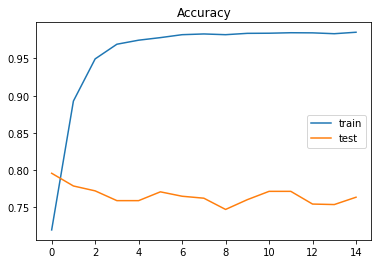

In [32]:
# Plotting accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Submitting to Kaggle

In [34]:
df_test['cleaned_text'] = df_test['text'].apply(lambda x : tweet_cleaner(x))

corpus_test = create_corpus(df_test)
sequences_test = tokenizer.texts_to_sequences(corpus_test)

corpus_pad_test = pad_sequences(sequences_test, maxlen=MAX_LEN, truncating='post', padding='post')

100%|██████████| 3263/3263 [00:00<00:00, 7248.02it/s]


In [0]:
# Predicting on Kaggle's test set
final_predictions = model.predict(corpus_pad_test)

In [0]:
predictions = np.concatenate(final_predictions).round().astype(int)

In [0]:
# Packaging submission up
submission = pd.DataFrame(data={'target': predictions}, index=df_test['id'])
submission.index = submission.index.rename('id')
submission.to_csv('submission2.csv')

In [39]:
# Submitting to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission2.csv -m "Week8: Submission 2"

100% 22.2k/22.2k [00:00<00:00, 24.8kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets